# Applying GrandPrix on single-cell qPCR data of early developmental stages in mouse
_Sumon Ahmed_, 2017

This notebooks describes the flexible architecture of the GrandPrix by extending it to 2-D latent spaces. Models with both informative and non-informative priors are examined.

In [1]:
import pandas as pd
import numpy as np
from GrandPrix import GrandPrix

## Helper function

__MapTo01__ converts everything between [0,1]

In [2]:
def MapTo01(y):
    return (y.copy() - y.min(0)) / (y.max(0) - y.min(0))

## Data description

<a href="https://www.ncbi.nlm.nih.gov/pubmed/20412781" target="_blank">Guo et al. (2010)</a> generated gene expression profiles of 48 genes measured across 437 cells. Cells differentiate from the single cell stage into three different cell states in the 64 cell stage: trophectoderm (TE), epiblast (EPI), and primitive endoderm (PE).

The __GuoTrainingData.csv__ file contains the expression profiles of this dataset.

In [3]:
Y = pd.read_csv('../data/Guo/GuoTrainingData.csv', index_col=[0])

In [4]:
N, D = Y.shape
print('Cells: %s, Genes: %s'%(N, D))

Cells: 437, Genes: 48


## Extending the model to 2-D space

We demonstrated the importance of this additional flexibility using a two-dimensional latent space where pseudotime is estimated jointly with the developmental branching structure.

In [5]:
latent_dims = 2
M = 40 # Number of inducing points

## Model with Informative prior

Capture time points have been used as the informative prior information over pseudotime. Following arguments have been passed to initialize the model.

<!--
-  __data__: _array-like, shape N x D_. Observed data, where N is the number of time points and D is the number of genes.
-  __latent_prior_mean__: _array-like, shape N_ x 1, _optional (default:_ __0__). > Mean of the prior distribution over pseudotime.
-  __latent_prior_var__: _array-like, shape N_ x 1, _optional (default:_ __1.__). Variance of the prior distribution over pseudotime.
-  __latent_mean__: _array-like, shape N_ x 1, _optional (default:_ __1.__). Initial mean values of the approximate posterior distribution over pseudotime.
-  __latent_var__: _array-like, shape N_ x 1, _optional (default:_ __1.__). Initial variance of the approximate posterior distribution over pseudotime.
- __kernel:__ _optional (default: RBF kernel with lengthscale and variance set to 1.0)_. Covariance function to define the mapping from the latent space to the data space in Gaussian process prior.
-->

-  __data__: _array-like, shape N x D_. Observed data, where N is the number of time points and D is the number of genes.


-  __n_latent_dims__: _int_. Number of latent dimentions to compute.


-  __n_inducing_points__: _int_. Number of inducing points.


-  __latent_prior_mean__: _array-like, shape N_ x 1. Mean of the prior distribution over pseudotime.


-  __latent_prior_var__: _array-like, shape N_ x 1. Variance of the prior distribution over pseudotime.

<!--
-  __latent_mean__: _array-like, shape N_ x 1. Initial mean values of the approximate posterior distribution over pseudotime.
-->

-  __latent_var__: _array-like, shape N_ x 1. Initial variance of the approximate posterior distribution over pseudotime.

<!--
- __kernel:__. Covariance function to define the mapping from the latent space to the data space in Gaussian process prior.


-  __inducing_inputs__: _array-like, shape_ _n_\__inducing_\__points_ x 1. Inducing input variables in the space of latent variables. 
-->

In [6]:
ct = np.zeros(N)
for il, l in enumerate(Y.index):
    s = l.split(' ')
    ct[il] = int(s[0])
prior_mean = np.zeros((N, latent_dims))
prior_mean[:, 0] = MapTo01(ct) 
prior_var = .1
X_var = 0.028

In [7]:
np.random.seed(10)
pt_wp, var_wp = GrandPrix.fit_model(data=Y.values, n_latent_dims=latent_dims, n_inducing_points=M,
               latent_prior_mean=prior_mean, latent_prior_var=prior_var, latent_var=X_var)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 19880.223198
  Number of iterations: 672
  Number of functions evaluations: 727


## Model without using Informative prior
<!--
-  Only observed data points have been used.
-->

In [8]:
pt_np, var_np = GrandPrix.fit_model(data=Y.values, n_latent_dims=latent_dims, n_inducing_points = M, latent_var=X_var)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 20328.332639
  Number of iterations: 688
  Number of functions evaluations: 755


# 2-D Visualization
The informative prior on capture time helps with the identifiability of the model as it aligns the first latent dimension (horizontal axis) with pseudotime and the second latent dimension (vertical axis) with the branching structure.

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
from utils import plot_XY

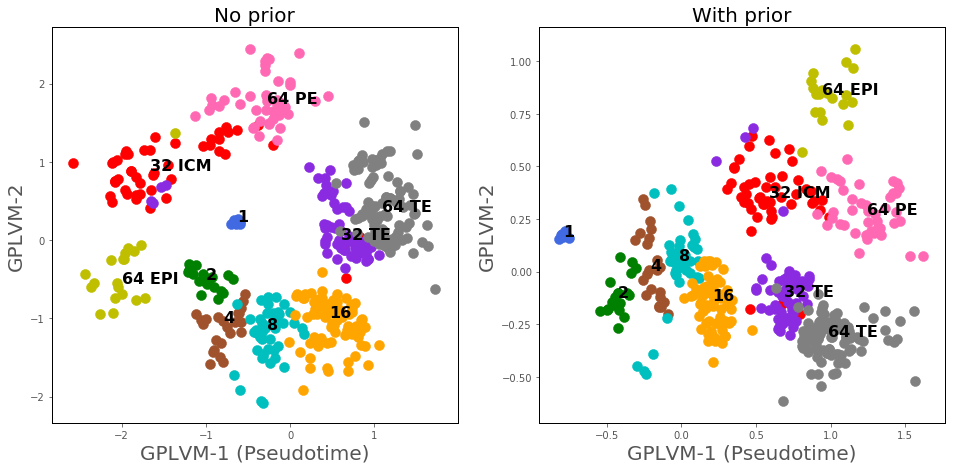

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 16))
plt.subplot(2, 2, 1)
plot_XY(pt_np[:,0], pt_np[:,1], 'No prior', Y.index)
plt.subplot(2, 2, 2)
plot_XY(pt_wp[:,0], pt_wp[:,1], 'With prior', Y.index)

## 1-D optimization
The 1-D pseudotime model with informative prior.

In [11]:
prior_mean_1D = prior_mean[:,0][:,None]

In [12]:
np.random.seed(10)
pt_wp_1D, var_wp_1D = GrandPrix.fit_model(data=Y.values, n_inducing_points=30,
               latent_prior_mean=prior_mean_1D, latent_prior_var=prior_var, latent_var=X_var)

## Comparison to the actual capture time
The 2-D model estimate of the pseudotime is found to have better correspondence with the actual capture time (correlation 0.84 vs 0.95), suggesting that the 1-D model is less able to align all variation with a pseudotime axis.

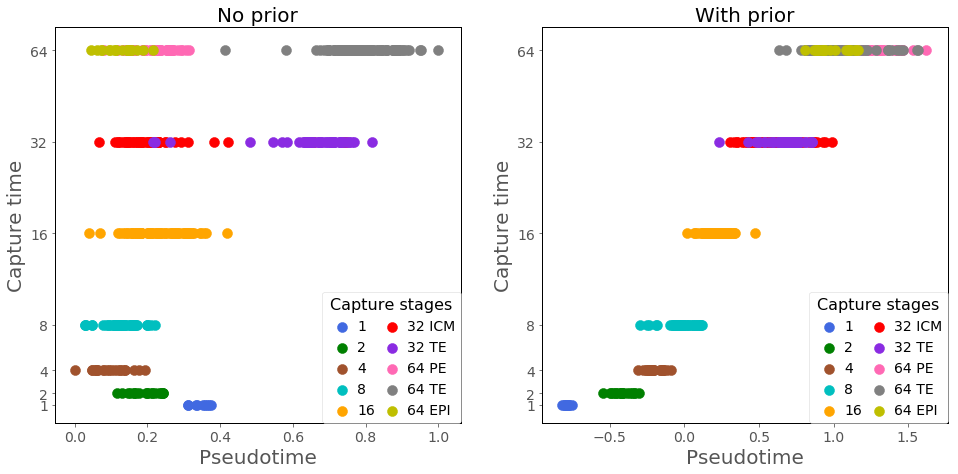

In [13]:
from utils import plotcorrelation
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 16))
plt.subplot(2, 2, 1)
plotcorrelation(pt_wp_1D[:, 0], ct, 'No prior', Y.index)
plt.subplot(2, 2, 2)
plotcorrelation(pt_wp[:, 0], ct, 'With prior', Y.index)

## Plot marker genes
* _Id2_ - a known marker gene for TE, thus it behaves differently in TE cells from the other two differentiation stages.
* _Gata4_ - Gata4 is differentially expressed between the stages (PE and EPI) and between the stages (TE and PE).

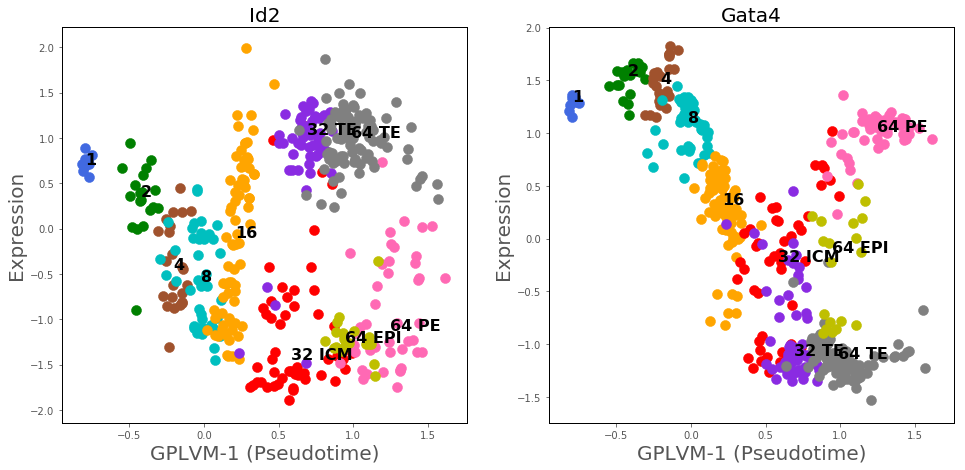

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 16))
plt.subplot(2, 2, 1)
plot_XY(pt_wp[:,0], -Y['Id2'], 'Id2', Y.index, ylabel='Expression')
plt.subplot(2, 2, 2)
plot_XY(pt_wp[:,0], -Y['Gata4'], 'Gata4', Y.index, ylabel='Expression')

##  Expression profiles of the top 10 differentially expressed genes between the stages TE and EPI

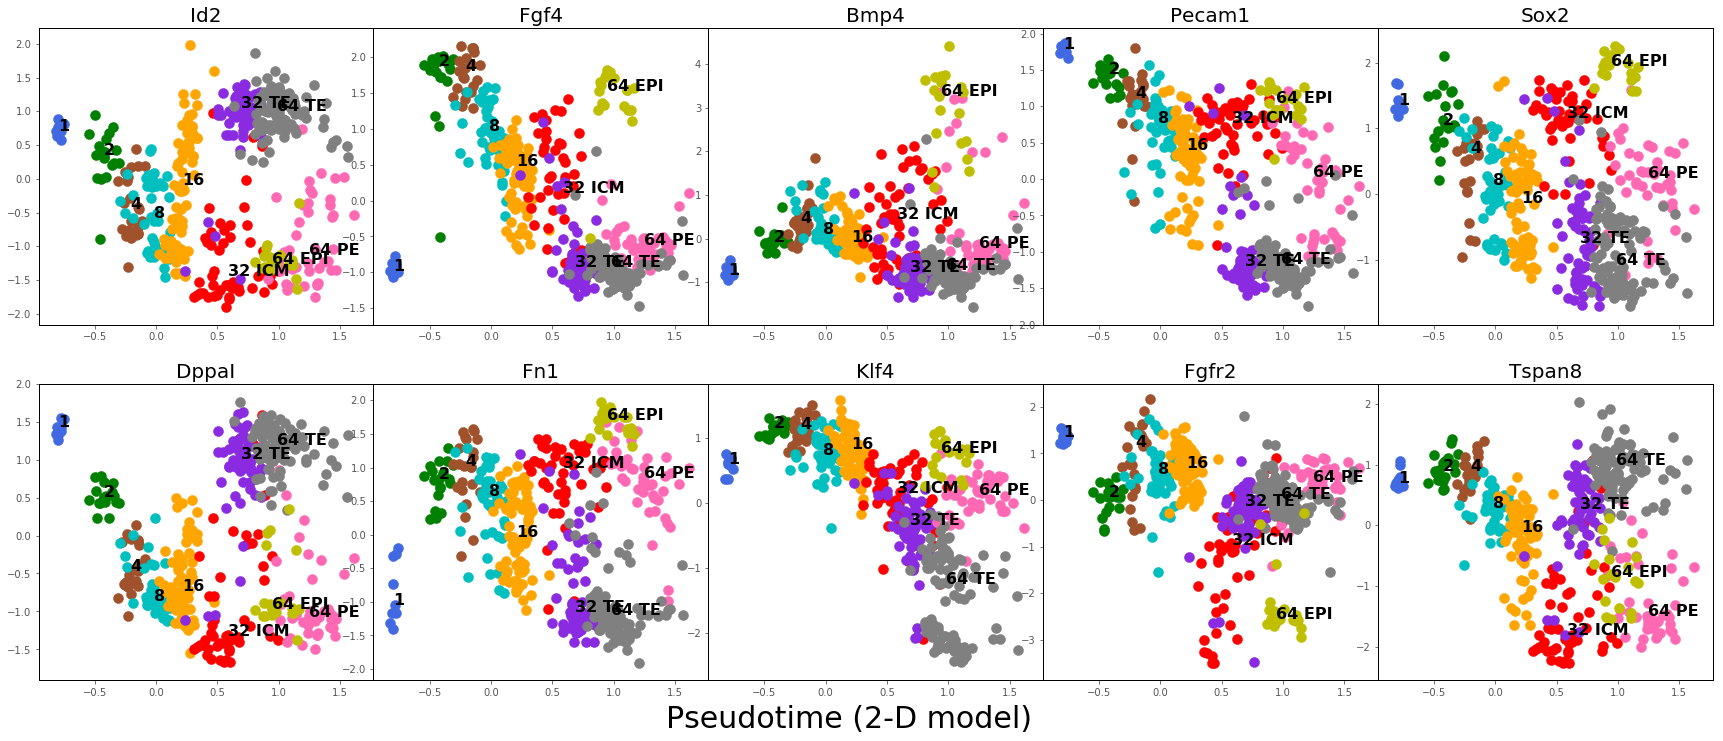

In [15]:
genes_TE_EPI = ['Id2', 'Fgf4', 'Bmp4', 'Pecam1', 'Sox2', 'DppaI', 'Fn1', 'Klf4', 'Fgfr2', 'Tspan8']
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(30, 12))
fig.subplots_adjust(wspace=0)
fig.text(0.5, 0.08, 'Pseudotime (2-D model)', ha='center', va='center', fontsize=30)
g = 0
for row in ax:
    for col in row:
        plt.subplot(2, 5, g + 1)
        plot_XY(pt_wp[:,0], -Y[genes_TE_EPI[g]], genes_TE_EPI[g], Y.index, xlabel='', ylabel='')
        g = g + 1

##  Expression profiles of the top 10 differentially expressed genes between the stages PE and EPI

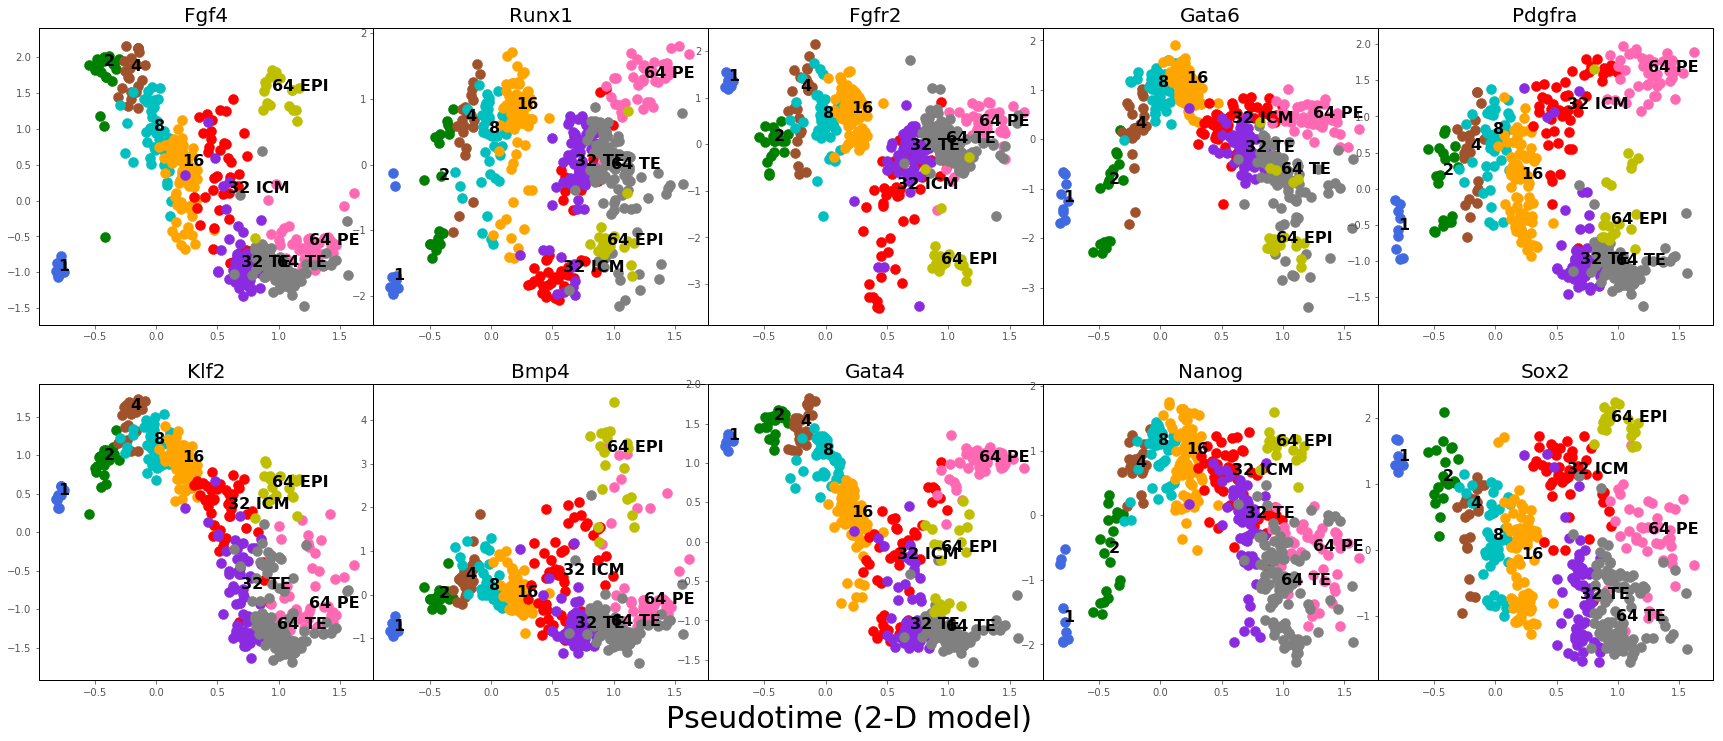

In [16]:
genes_PE_EPI = ['Fgf4', 'Runx1', 'Fgfr2', 'Gata6', 'Pdgfra', 'Klf2', 'Bmp4', 'Gata4', 'Nanog', 'Sox2']
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(30, 12))
fig.subplots_adjust(wspace=0)
fig.text(0.5, 0.08, 'Pseudotime (2-D model)', ha='center', va='center', fontsize=30)
# fig.text(0.1, 0.5, 'Gene Expression', ha='center', va='center', rotation='vertical', fontsize=12)
g = 0
for row in ax:
    for col in row:
        plt.subplot(2, 5, g + 1)
        plot_XY(pt_wp[:,0], -Y[genes_PE_EPI[g]], genes_PE_EPI[g], Y.index, xlabel='', ylabel='')
        g = g + 1

##  Expression profiles of the top 10 differentially expressed genes between the stages TE and PE

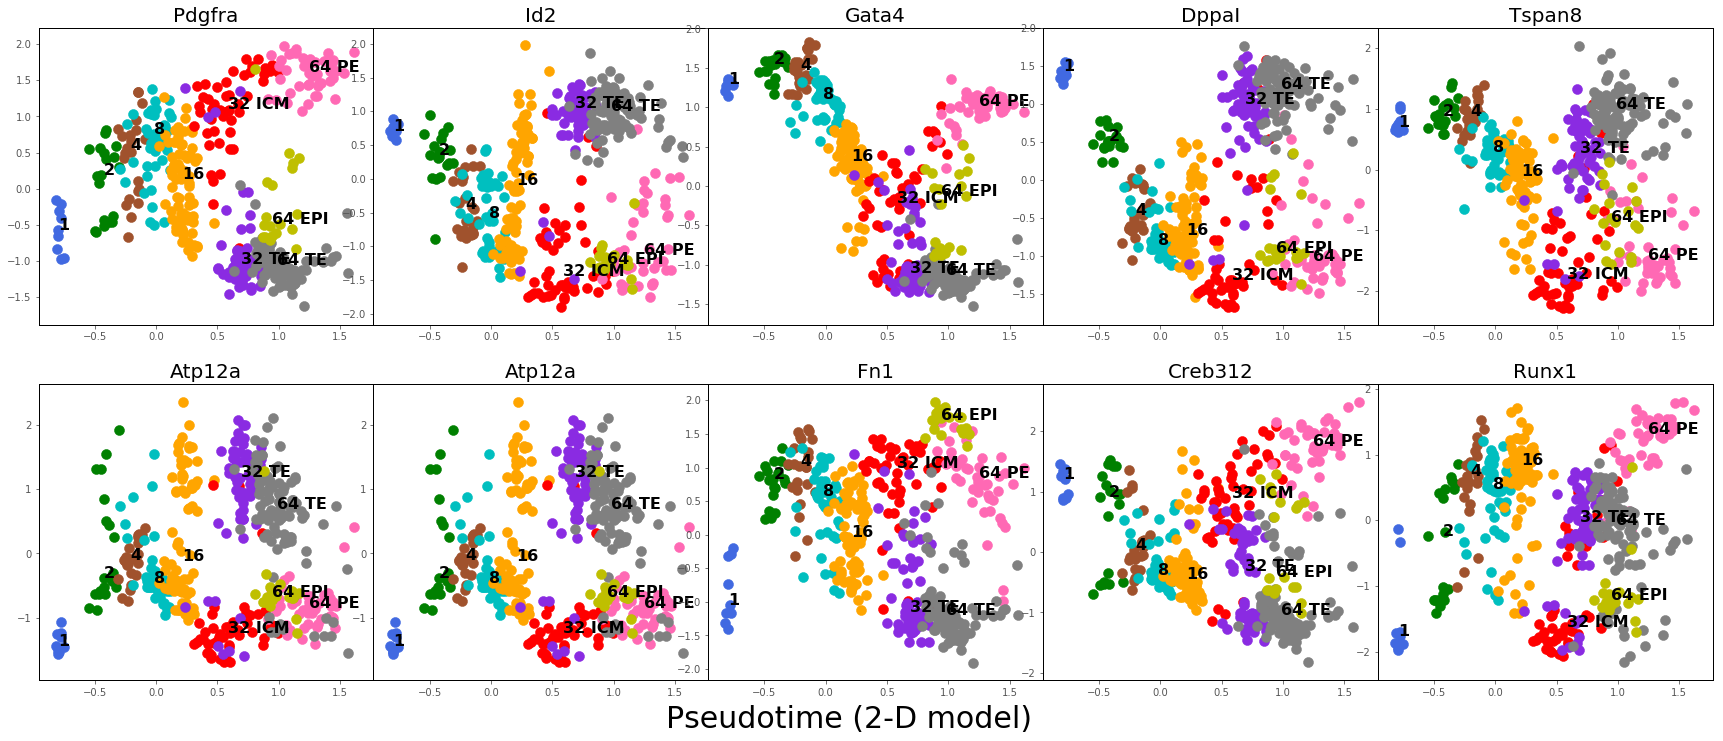

In [17]:
genes_TE_PE = ['Pdgfra', 'Id2', 'Gata4', 'DppaI', 'Tspan8', 'Atp12a', 'Atp12a', 'Fn1', 'Creb312', 'Runx1']
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(30, 12))
fig.subplots_adjust(wspace=0)
fig.text(0.5, 0.08, 'Pseudotime (2-D model)', ha='center', va='center', fontsize=30)
g = 0
for row in ax:
    for col in row:
        plt.subplot(2, 5, g + 1)
        plot_XY(pt_wp[:,0], -Y[genes_TE_PE[g]], genes_TE_PE[g], Y.index, xlabel='', ylabel='')
        g = g + 1

## Robustness of the model with regards to deviations in the prior variance of pseudotime

In [18]:
varDf = pd.read_csv('../data/Guo/guo_prior_variance_values.csv', index_col=[0])

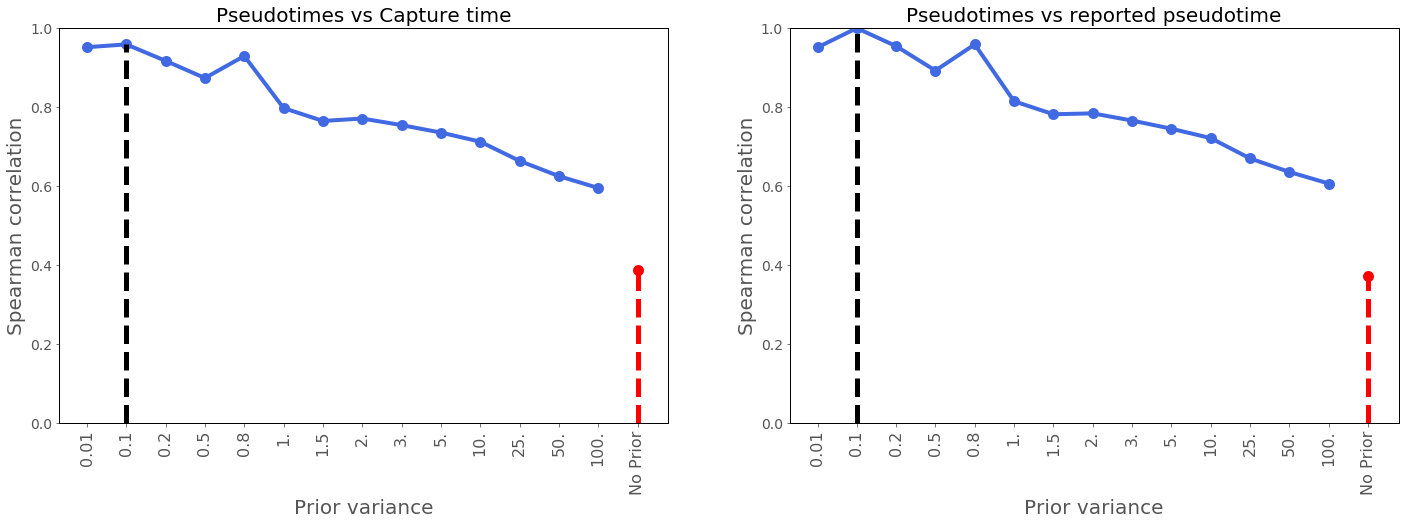

In [20]:
from scipy.stats import spearmanr
from matplotlib import pyplot as plt
from utils import plot_robustness_across_prior_variance
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(24, 16))
plt.subplot(2, 2, 1)
plot_robustness_across_prior_variance(varDf['correlation'], spearmanr(pt_np[:,0], ct)[0], 
                                      'Pseudotimes vs Capture time', 'Prior variance', 'Spearman correlation')
plt.subplot(2, 2, 2)
plot_robustness_across_prior_variance(varDf['cor_var_reported_pt'], spearmanr(pt_np[:,0], pt_wp[:,0])[0],
               'Pseudotimes vs reported pseudotime', 'Prior variance', 'Spearman correlation')